# Milestone 4 Deep Learning
-----

## Instructions


Milestone 4: Deep learning, due Wednesday, April 26, 2017

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

### Description of Data

We first resize the movie posters to be 32 x 32 x 3 so these are our features. The labels for each movie are the intersection of the genres in IMDb and TMDb. Ultimately, this left us with 17 genres: Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, History, Horror, Mystery, Romance, Science Fiction, Thriller, War and Western. We're performing a multi-label classification problem, so a movie can be assigned more than 1 of the genres listed above.

Our resulting data set is split- 20% of the examples are assigned to the test set, and 80% of the examples are assigned to the training set. This results in 11,757 training movies, each of dimension 32 x 32 x 3, and 2,940 testing movies of the same dimension. 


### Description of deep network trained from scratch

Because we're dealing with a multi-label classification problem, we changed the loss function to be **binary cross-entropy** and the last layer's activation to be the sigmoid function.

Binary cross-validation between a target ($t$) and output ($o$) tensor is defined as binary_crossentropy $ = -(t*log(o) + (1-t)*log(1-o))$. When dealing with multi-label, the overall binary_crossentropy is defined as the mean of the individual binary cross-entropies of each class.

We originally performed cross-validation on the number of convolutional layers (1-3), the number of dense layers (1-2), and the learning rate for ADAM (0.0001,0.005,0.01,0.05,0.1). We used a batch size of 256 and 50 epochs for each trial.

During our first trials, we found that we were getting a very high accuracy of ~91%. This is very misleading, however, because we have a sparse output matrix, so even though our output probabilities were very low (and therefore, considered to be zero when calculating accuracy), we were getting a very high accuracy. 

We looked into two solutions for this problem: 

1. Firstly, we decided to use the F1 score, then, since this would be a better metric for differentiating between models. F1 score is the harmonic mean between precision and recall. In multilabel problems, there are two ways to calculate F1 score for results: "micro" and "macro." The "micro" calculation would use precision and recall that have been calculated over all genres, whereas the "macro" calculation caculates the F-score for each genre separately, and averages the values. Both can be useful perspectives, but the macro calculation may be more useful for our comparison, since that is what we were using for some of our machine learning models from Milestone 3.

2. Secondly, we added a thresholded accuracy function which predicts a 1 if the probability is greater than 0.1. This will solve the skew towards low probabiltiies.

To implement these solutions, we explored writing custom metrics using the tensorflow backend. We completed three metrics--precision, recall, and accuracy_with_threshold to change the threshold to lower than 0.5. In addition, we wrote functions to compute precision, recall, and threshold for each model's final predictions.

**Added Functionality**

We experimented with Dropout layers as well as an adaptive learning rate. For the dropout layers, 20% of the nodes are dropped and we vary where these layers are placed. For the adaptive learning rate we use the callback function called ReduceLROnPlateau. We have it monitor the thresholded accuracy function and vary the factor by which the learning rate is reduced by (0.01 or 0.05) as well as the minimum learning rate (0.001 or 0.0001). Again we use a batch size of 256 and 60 epochs per trial.


### Description of pre-trained network that we fine tuned

### Results and comparison between trained and pre-trained networks

**Trained From Scratch**  

For our trained network, as described above we run cross-validation on the number of convolutional and dense layers, the learning rate for ADAM, the number/placement of Dropout layers, and the ReduceLROnPlateau adaptive rate reduction factor and minimum learning rate. 

We found that model with the lowest F1 score has one dense and one convolutional layer, no dropout layers, a learning rate of 0.001, and minimum adaptive learning rate of 0.0001 and an adaptive learning rate reduction factor of 0.01.

When the predictions are thresholded by 0.1, this model has a F1 score of 33.97%, precision of 22.78% and recall of 64.21%. 

**Pre-Trained**  

We also fine-tuned the pre-trained VGG16 network provided through a library interface in keras. This model features 13 convolutional layers, to which we added additional dense layers for fine-tuning. After freezing the first layers of the pre-trained network, we trained the remaining layers of the compound model using cross-validated values for the fixed learning rate. 

We found that the pre-trained network achieved very similar performance to the model that was constructed and trained from scratch, for fixed values of the learning rate. Increasing the learning rate appearred to produce worse performance for all but the precision score. 

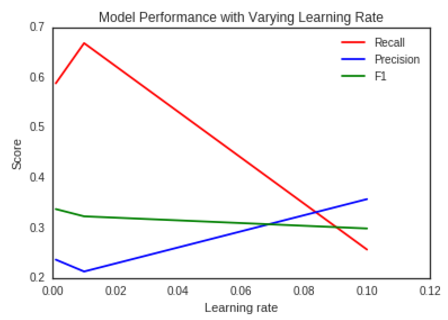

In [1]:
from IPython.display import Image
Image(filename="vgg16.png")

### Description of exploratory idea 

We explored an adaptive learning rate (by ReduceLROnPlateau) as well as using Dropout layers, as described above. Besides this we also looked at defining a custom loss function to help account for the imbalance in our dataset. Because some genres are so uncommon in our dataset (take History for example), the models we produced learning to predict 0 for each movie. If we cared particularly about the History genre (while still wanting to use the multi-label problem so that the information from the other genres is used), then a way to combat this problem is through a weighted loss function.

We produce a weighted binary cross-entropy loss function which is defined as:

In [4]:
from functools import partial
from itertools import product
import numpy as np
def weighted_binary_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)* final_mask

ncce = partial(weighted_binary_crossentropy, weights=np.ones((17,17)))
ncce.__name__ ='weighted_binary_crossentropy'

Then we just need to define the weight matrix. In weight matrix rows (i) and columns (j) represent the different classes. Then w[i,j] represents the cost for incorrectly misclassifying genre i as genre j.

We experiment with what happens when we set high costs for misclassifying a History genres movie as any other genre. This hurts our results (f1, accuracy, etc.) but we do see that its effective in forcing the model to do more than just predicting 0 for the History genre for each movie.

For example, without weights we get:  

Action Predicted: 1887   
Adventure Predicted: 344   
Animation Predicted: 712   
Comedy Predicted: 2913   
Crime Predicted: 1258   
Documentary Predicted: 1171  
Drama Predicted: 2940  
Family Predicted: 371   
Fantasy Predicted: 2   
History Predicted: 0   
Horror Predicted: 1061   
Mystery Predicted: 36   
Romance Predicted: 2135   
Science Fiction Predicted: 309   
Thriller Predicted: 1583   
War Predicted: 1   
Western Predicted: 34   

Note that the History genre is never predicted. Then with weights we get:  

Action Predicted: 2755  
Adventure Predicted: 2257  
Animation Predicted: 2266  
Comedy Predicted: 2940  
Crime Predicted: 2587  
Documentary Predicted: 2783  
Drama Predicted: 2940  
Family Predicted: 2009  
Fantasy Predicted: 1385  
History Predicted: 12  
Horror Predicted: 1960  
Mystery Predicted: 1016  
Romance Predicted: 2669  
Science Fiction Predicted: 1600  
Thriller Predicted: 2796  
War Predicted: 425  
Western Predicted: 378  

Now we see that 12 Movies are being predicted as History movies.

If the classification problem has clear costs for predicting one class over another, this would be a useful approach. In our case, we don't particularly see differences in costs between predicting one genre versus another, so the decrease in accuracy/f1 score from this approach makes it not a worthwhile addition into our model.